Buoni parametri:  
- input_size = 2  
- hidden_size = 7  
- activation_fun = nn.Tanh()  
- learning_rate = 0.001  
- epochs = 10000 
- loss_fun = nn.MSELoss()  

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pylab as plt
from scipy.optimize import curve_fit
import torch
from torch import autograd, nn
import torch.nn.functional as F
import torch.optim as optim
import functions as f
from tqdm import tqdm

**ATTENZIONE!!!**  
Usando add_bool2 si ha un train_set di 113 elementi e un test_set di 56


In [2]:
data = pd.read_csv('data_fs.dat', delim_whitespace=True, decimal=",")
f.add_bool(data)

### Data_train

In [3]:
x = data["x"][data['check'] == True]
y = data["y"][data['check'] == True]

X_train = np.stack((x.values, y.values), axis=1)
X_train = torch.from_numpy(X_train).float()

Normalizzo i dati dell'ellitticità in modo da ottenere un risultato che sia sempre compreso tra -1 e 1.   
Il fatto di scegliere come range -1 e 1 è dettato dalla scelta della Tanh come funzione di attivazione, il cui codominio è proprio (-1,1).  
`normalization1` normalizza i dati tra 0 e 1  
`normalization2` normalizza i dati tra -1 e 1

In [4]:
y_train = data["e"][data['check'] == True]
y_train = f.normalization2(y_train)
y_train = torch.squeeze(torch.from_numpy(y_train.to_numpy()).float())

### Data_test

In [5]:
x = data["x"][data['check'] == False]
y = data["y"][data['check'] == False]

X_test = np.stack((x.values, y.values), axis=1)
X_test = torch.from_numpy(X_test).float()

y_test = data["e"][data['check'] == False]

m_test = 2/(y_test.max() - y_test.min())
q_test = (y_test.min() + y_test.max()) / (y_test.min() - y_test.max())

y_test = y_test * m_test + q_test

y_test = torch.squeeze(torch.from_numpy(y_test.to_numpy()).float())

print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

torch.Size([85, 2]) torch.Size([85])
torch.Size([84, 2]) torch.Size([84])


### Set Parameters

In [6]:
input_size = 2
hidden_size = 1
activation_fun = nn.Tanh()
learning_rate = 0.001
epochs = 10000
loss_fun = nn.MSELoss()

In [7]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        
        self.hidden = nn.Linear(input_size, hidden_size)
        self.activation = activation_fun
        self.output = nn.Linear(hidden_size, 1)
        
    def forward(self, input):
        hidden = self.hidden(input)
        activated = self.activation(hidden)
        output = self.output(activated)
        
        return self.activation(output)

In [8]:
net = Net()
opt = optim.Adam(net.parameters(), lr=learning_rate) #che valore di lr usare??

In [9]:
net.eval()

y_pred = net(X_test)
y_pred = torch.squeeze(y_pred)
before_train = loss_fun(y_pred, y_test)
print('Test loss before Training' , before_train.item())

Test loss before Training 0.32113415002822876


In [10]:
net.train()

training = []
validation = []

for epoch in tqdm(range(epochs)):
    opt.zero_grad()
    y_pred = net(X_train)
    y_pred = torch.squeeze(y_pred)
    train_loss = loss_fun(y_train, y_pred)
    training.append(train_loss)
    
    
    with torch.no_grad():
        y_val = net(X_test)
        y_val = torch.squeeze(y_val)
        val_loss = loss_fun(y_val, y_test)
        assert val_loss.requires_grad == False
        validation.append(val_loss)
    
    train_loss.backward()
    opt.step()

100%|██████████| 10000/10000 [00:12<00:00, 825.29it/s]


In [11]:
net.eval()

y_pred = net(X_test)
y_pred = torch.squeeze(y_pred)
after_train = loss_fun(y_pred, y_test)
print('Test loss after Training' , after_train.item())
if before_train < after_train:
    print('OVERFITTING')
else:
    print('Everything is ok')

Test loss after Training 0.13335135579109192
Everything is ok


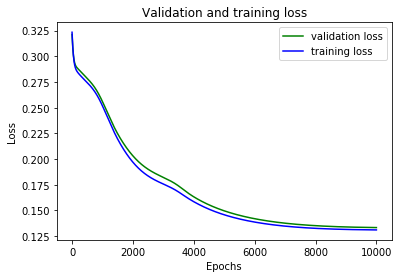

In [12]:
plt.plot(validation, linestyle='-', color='green', label='validation loss')
plt.plot(training, linestyle='-', color='blue', label='training loss')
plt.title('Validation and training loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

Converto la normalizzazione iniziale

0     -0.316965
2     -0.319138
4     -0.321053
6     -0.321458
8     -0.321053
         ...   
160    0.329983
162    0.329709
164    0.329983
166    0.331717
168    0.335293
Name: x, Length: 85, dtype: float64


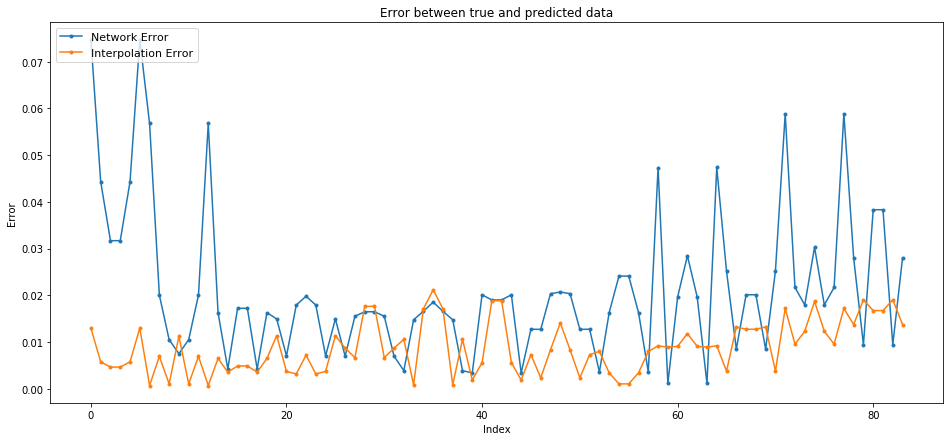

In [28]:
predicted = torch.squeeze( ((net(X_test) - q_test) / m_test).float() )
true = torch.squeeze( ((y_test - q_test) / m_test ).float())

data_int = data[data['check'] == True]
data_check = data[data['check'] == False]
X_int = [data_int["x"], data_int["y"]]
X_check = [data_check["x"], data_check["y"]]
popt, pcov = curve_fit(f.func, X_int, data_int["e"])
test_func_e = f.func(X_check, *popt)
fig = plt.figure(figsize=(16, 7))
plt.plot(abs(predicted - true).detach().numpy(), marker='.', ls='-', label='Network Error')
plt.title('Error between true and predicted data')
plt.xlabel('Index')
plt.ylabel('Error')
plt.plot(np.array(abs(test_func_e-data_check["e"])), marker='.', ls='-', label='Interpolation Error')
plt.legend(loc='upper left', fontsize=11)

In [14]:
net.hidden.weight.data, net.hidden.bias.data

(tensor([[ 6.2266e+00, -1.1547e-06]]), tensor([-2.5811]))

In [15]:
X_test[0], net(X_test)

(tensor([-0.3182,  0.2720]), tensor([[-0.7253],
         [-0.7253],
         [-0.7253],
         [-0.7253],
         [-0.7253],
         [-0.7253],
         [-0.7250],
         [-0.7250],
         [-0.7250],
         [-0.7250],
         [-0.7250],
         [-0.7250],
         [-0.7250],
         [-0.7244],
         [-0.7245],
         [-0.7245],
         [-0.7245],
         [-0.7245],
         [-0.7244],
         [-0.7233],
         [-0.7233],
         [-0.7234],
         [-0.7234],
         [-0.7234],
         [-0.7233],
         [-0.7233],
         [-0.7211],
         [-0.7212],
         [-0.7213],
         [-0.7213],
         [-0.7212],
         [-0.7211],
         [-0.7166],
         [-0.7169],
         [-0.7171],
         [-0.7171],
         [-0.7171],
         [-0.7169],
         [-0.7166],
         [-0.7080],
         [-0.7085],
         [-0.7087],
         [-0.7087],
         [-0.7085],
         [-0.7080],
         [-0.6896],
         [-0.6907],
         [-0.6914],
         [-0

**Osservazioni/Dubbi:**  
- Ad ogni riavvio del kernel i risultati della loss prima e dopo il training variano (spesso anche di un'unità). Credo che questo sia dovuto al fatto che inizialmente i weights e biases siano impostati casualmente -> c'è un modo per ovviare questo "problema"
- I dati che ho per il training (85) sono "tanti o pochi" relativamente al mio task?
- Scelta epoche --> con 10000 epoche i risultati migliorano, ma è "legale"?
- Non capisco se la rete sta imparando e/o se va in overfitting
- Cosa fa esattamente il comando .view(-1)?
- Ho provato a normalizzare i dati tra 0 e 1 e utilizzare come funzione di attivasione `Sigmoid` ma è meglio normalizzare tra -1 e 1 e utilizzare `Tanh`
- Se uso `Tanh` come funzione di attivazione l'ouput della rete non dovrebbe essere sempre compreso tra -1 e 1?! Se però non normalizzo l'input mi escono risultati >1. 
- Vorrei valutare l'accuracy ma non so bene come fare
- Fatto interessante: se aumento il numero di elementi nel train_set non è affatto detto che le cose migliorino. Esempio:
    * add_bool vs add_bool2 con:
        * input_size = 2
        * hidden_size = 5
        * activation_fun = nn.Tanh()
        * learning_rate = 0.001
        * epochs = 50
        * loss_fun = nn.MSELoss()
- con 30000 epoche e i soliti parametri l'errore della rete è praticamente sempre minore di quello dell'interpolazione
        